# Introduction

The Paradis corpus (Paradis, 2005) consists of naturalistic language samples from 25 children learning English as a second language (English language learners or learners of English as an additional language). The corpus is longitudinal, with five rounds of data collection spanning a two‐year period.

Transcription is in English orthography only; phonetic transcription was not included in this research. The design of the study was longitudinal, but only 19 of the 25 participants have data for all five rounds. Any real names of people or places in the transcripts have been replaced with pseudonyms. The participants are identified with four letter codes. 

In this notebook, we'll be conducting an initial Exploratory Data Analysis (EDA) on the dataset.

## The EDA

First, we'll load the dataset using pandas.  If we look at guide_to_files.csv, we'll want to expand out the gender type.

In [105]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

list_children = pd.read_csv('guide_to_files.csv')

list_children.loc[list_children['gender'] == 'M', 'gender'] = 'Male'
list_children.loc[list_children['gender'] == 'F', 'gender'] = 'Female'

list_children.head()

,file_name,first_language,gender,age_of_arrival_to_Canada_months,age_of_English_exposure_months,age_at_recording_months,months_of_english
0,bnfs1.cha,Farsi,Female,58,63,73,10
1,brnd1.cha,Spanish,Male,53,56,66,10
2,chrs1.cha,Romanian,Female,69,69,74,5
3,cndx1.cha,Mandarin,Female,73,73,81,8
4,dnln1.cha,Cantonese,Male,1,48,62,14


Next, let's determine how many people with first languages are being interviewed.

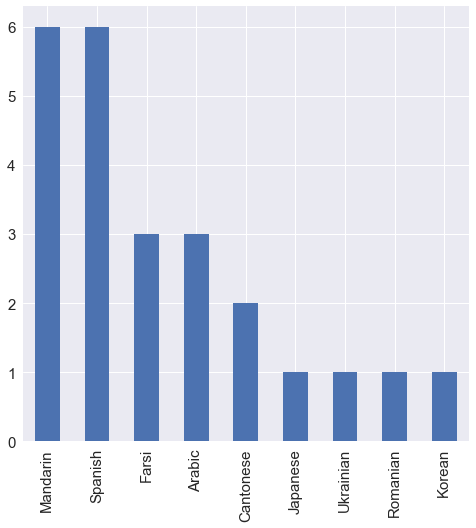

In [106]:
list_children['first_language'].value_counts().plot(kind='bar',figsize=(8,8), fontsize=15)

We noticed that most of the children either have Spanish or Mandarin as their first language.

Now, let's determine whether there is a male or female majority.

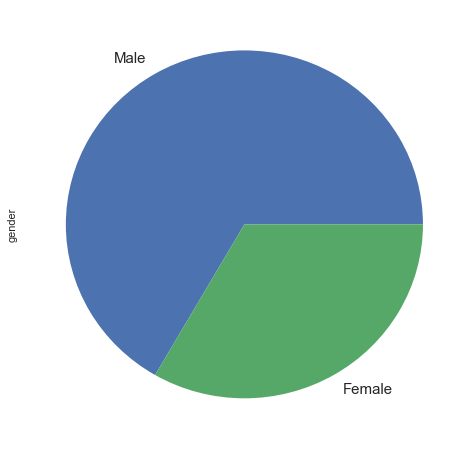

In [107]:
list_children['gender'].value_counts().plot(kind='pie',figsize=(8,8), fontsize=15)

It looks like about 2/3 of the participants are male.

I would like to see how long it takes for the children to be exposed to English after arriving to Canada.  This can have an effect on whether they would have more speech imperfections for English.

Minimum: 0
Maximum: 56
Mean: 12.208333333333334


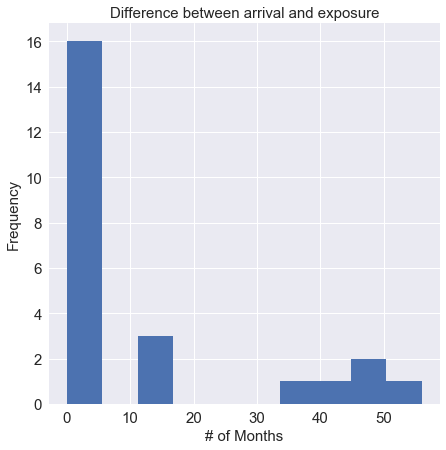

In [108]:
dif_time = list_children['age_of_English_exposure_months'] - list_children['age_of_arrival_to_Canada_months']
print("Minimum: {}".format(dif_time.min()))
print("Maximum: {}".format(dif_time.max()))
print("Mean: {}".format(dif_time.mean()))

plt.title('Difference between arrival and exposure', fontsize=15)
plt.xlabel('# of Months', fontsize=15)
plt.ylabel('# of Children', fontsize=15)
dif_time.plot(kind = 'hist', figsize=(7,7), fontsize=15)

At best, they'll be exposed to English around the same time they arrived to Canada.  The longest time to be exposed to English was almost 5 years!

Despite this extreme, it's common for children to be exposed about a year after they came to the country.

An interesting question would be whether the difference of the age of exposure and the age of recording are the same as the number of months that the person was learning English.

In [109]:
(list_children['age_at_recording_months'] - list_children['age_of_English_exposure_months']) == list_children['months_of_english']

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23    False
dtype: bool

With the exception of the last dataset, this is the case.  Upon listing the last entry, we notice that the child was learning English well before he was exposed to the language.  How is this possible?

According to the description, all language learning takes place after the first language is established.  However, it's never defined how a person is exposed to English (oral, reading, writing).

In [110]:
list_children.tail(1)

,file_name,first_language,gender,age_of_arrival_to_Canada_months,age_of_English_exposure_months,age_at_recording_months,months_of_english
23,yssf1.cha,Arabic,Male,1,57,59,9


## Recording number of imperfections

Now that we took a look at the dataset, let's discover the following

* How many silences
* How many interruptions
* How many "um's", "uh's", and "mm's"

Any listed item will be defined as an imperfection.

In [111]:
import re

def getDialog(filename):
    dialog = []
    file = open(filename.strip(),'r')
    for line in file:
        if line[0] == '*':
            new_line = line[1:].strip()
            new_line = new_line[:4] + new_line[5:]
            dialog.append(new_line)
    file.close()
    return dialog

def analyzeDialog(dialog):
    pauses = 0
    ums = 0
    interrupts = 0
    for index, line in enumerate(dialog):
        if line[:3] == 'CHI':
            tmpline = line[4:]
            ums += len(re.findall(r"&-[^\s]*",tmpline)) 
            pauses += len(re.findall(r"\(\.\.?\)",tmpline))
            interrupts += len(re.findall(r"<[^>]*>",tmpline))
            # Commented code removes some imperfections in the speech.
            #while len(re.findall(r"&-[^\s]*",tmpline)) != 0:
            #    match = re.search(r"&-[^\s]*",tmpline)
            #    tmpline = tmpline[:match.start()] + tmpline[match.end():]
            #    ums += 1
            #while len(re.findall(r"\(\.\.?\)",tmpline)) != 0:
            #    match = re.search(r"\(\.\.?\)",tmpline)
            #    tmpline = tmpline[:match.start()] + tmpline[match.end():]
            #    pauses += 1
            #while len(re.findall(r"<[^>]*>",tmpline)) != 0:
            #    match = re.search(r"<[^>]*>",tmpline)
            #    tmpline = tmpline[:match.start()] + tmpline[match.end():]
            #    interrupts += 1
            #while len(re.findall(r"\[[^\]]*\]",tmpline)) != 0:
            #    match = re.search(r"\[[^\]]*\]",tmpline)
            #    tmpline = tmpline[:match.start()] + tmpline[match.end():]
            #print(tmpline)
            #dialog[index] = dialog[index][:4] + tmpline                 
    return (pauses, ums, interrupts)

In [112]:
list_children['pauses'] = 0
list_children['ums'] = 0
list_children['interrupts'] = 0
list_children['imperfections'] = 0
for index, row in list_children.iterrows():
    #print(row)

    dialog = getDialog(row['file_name'])
    res = analyzeDialog(dialog)
    list_children.loc[index, 'pauses'] = res[0]
    list_children.loc[index, 'ums'] = res[1]
    list_children.loc[index, 'interrupts'] = res[2]
    list_children.loc[index, 'imperfections'] = sum(res)
list_children[['first_language', 'months_of_english', 'pauses', 'ums','interrupts', 'imperfections']].head(23)

,first_language,months_of_english,pauses,ums,interrupts,imperfections
0,Farsi,10,374,164,67,605
1,Spanish,10,86,109,67,262
2,Romanian,5,112,51,70,233
3,Mandarin,8,48,67,53,168
4,Cantonese,14,116,58,29,203
5,Mandarin,9,127,195,95,417
6,Mandarin,7,22,23,51,96
7,Spanish,8,35,20,64,119
8,Spanish,10,295,112,57,464
9,Korean,2,169,38,21,228


Now the question is whether we can make any meaningful between the amount of months learning English and any imperfections.

In [113]:
print("Correlation between imperfections and months of English: {}".format(
    list_children[['imperfections','months_of_english']].corr())
)

Correlation between imperfections and months of English:                    imperfections  months_of_english
imperfections           1.000000           0.231734
months_of_english       0.231734           1.000000


From just calculating the correlation, there isn't a strong connection between the two.  Let's see if there's any correlation between the age of the child and the amount of imperfections.

In [114]:
print("Correlation between imperfections and age of child: {}".format(
    list_children[['imperfections','age_at_recording_months']].corr())
)

Correlation between imperfections and age of child:                          imperfections  age_at_recording_months
imperfections                 1.000000                 0.109041
age_at_recording_months       0.109041                 1.000000


There doesn't appear to be any correlation between age and general imperfections as well.

Does age matter when saying ums?

Correlation between ums and age of child:                               ums  age_at_recording_months
ums                      1.000000                 0.069475
age_at_recording_months  0.069475                 1.000000


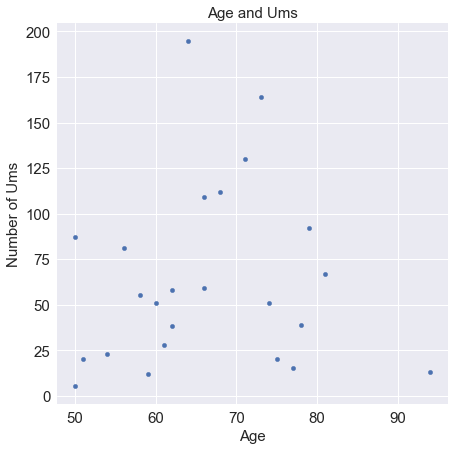

In [124]:
print("Correlation between ums and age of child: {}".format(
    list_children[['ums','age_at_recording_months']].corr())
)
list_children.plot(x='age_at_recording_months',y='ums', kind='scatter',figsize=(7,7),fontsize=15)
plt.title("Age and Ums", fontsize=15)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Number of Ums", fontsize=15)
plt.show()

There is no correlation between age and the number of ums made.  This isn't suprising since many adults say "um" as well.

How about age and pauses?

Correlation between pauses and age of child:                            pauses  age_at_recording_months
pauses                   1.000000                 0.070981
age_at_recording_months  0.070981                 1.000000


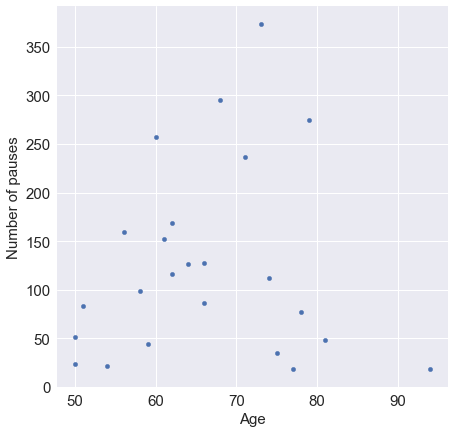

In [116]:
print("Correlation between pauses and age of child: {}".format(
    list_children[['pauses','age_at_recording_months']].corr())
)
list_children.plot(x='age_at_recording_months',y='pauses', kind='scatter',figsize=(7,7),fontsize=15)
plt.title("Age and Pauses", fontsize=15)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Number of pauses", fontsize=15)
plt.show()

There is no correlation between age and the number of pauses made.  However, let's try how strongly correlated the amount of time a child knows English will pause.

Correlation between interruptions and age of child:                     pauses  months_of_english
pauses             1.00000            0.23955
months_of_english  0.23955            1.00000


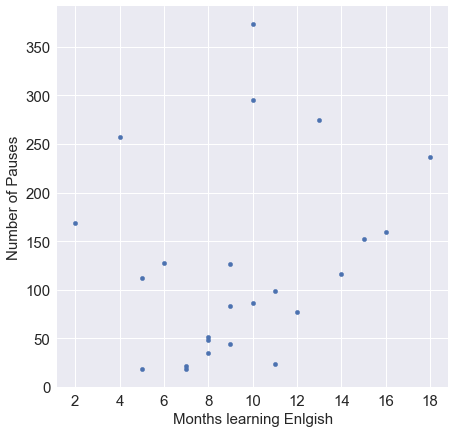

In [117]:
print("Correlation between pauses and age of child: {}".format(
    list_children[['pauses','months_of_english']].corr())
)
list_children.plot(x='months_of_english',y='pauses', kind='scatter',figsize=(7,7),fontsize=15)
plt.title("Months learning and pauses", fontsize=15)
plt.xlabel("Months learning Enlgish", fontsize=15)
plt.ylabel("Number of Pauses", fontsize=15)
plt.show()

There isn't much correlation.

How about age of the child and interruptions?

Correlation between interruptions and age of child:                          interrupts  age_at_recording_months
interrupts                 1.000000                 0.179481
age_at_recording_months    0.179481                 1.000000


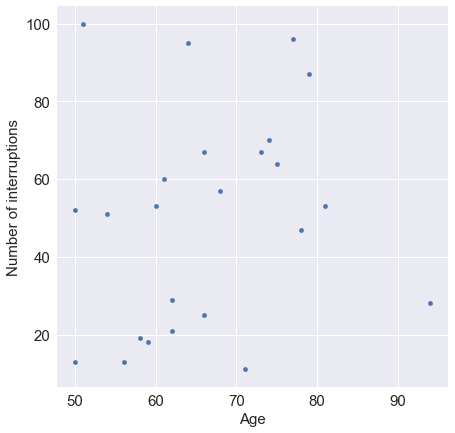

In [118]:
print("Correlation between interruptions and age of child: {}".format(
    list_children[['interrupts','age_at_recording_months']].corr())
)
list_children.plot(x='age_at_recording_months',y='interrupts', kind='scatter',figsize=(7,7),fontsize=15)
plt.title("Age and interruptions", fontsize=15)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Number of interruptions", fontsize=15)
plt.show()

There is still no correlation between age and the number of interruptions made.  However, this can be due to

1. The age of the child.  The younger the child, the more likely he'll interrupt.
2. The personality of the child.  Some people are more outspoken than others.

Despite not getting strong correlations, the data can describe the personality of a child.  For example, a child that made fewer interruptions might be either shy or obedient.

## Analyze by language

Since there wasn't much correlation between the imperfections and the age of the child, let's analyze between the imperfections and the children belonging to each language.

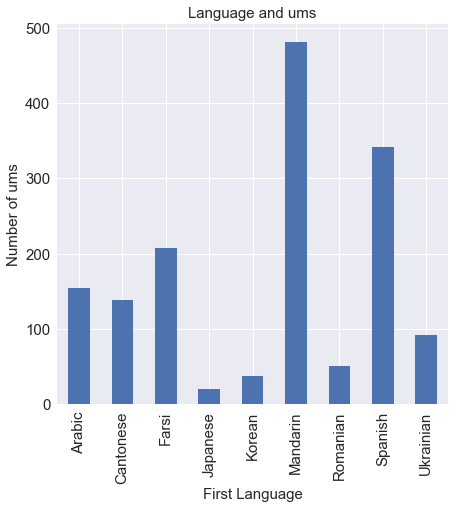

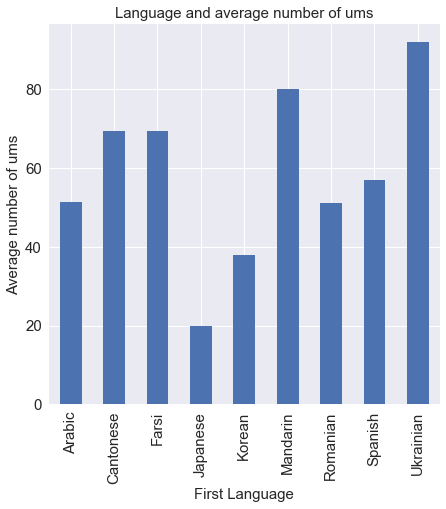

In [119]:
plt.title("Language and ums", fontsize=15)
list_children.groupby(['first_language'])['ums'].sum().plot(kind = 'bar', figsize= (7,7), fontsize=15)
plt.xlabel("First Language", fontsize=15)
plt.ylabel("Number of ums", fontsize=15)
plt.show()

plt.title("Language and average number of ums", fontsize=15)
list_children.groupby(['first_language'])['ums'].mean().plot(kind = 'bar', figsize= (7,7), fontsize=15)
plt.xlabel("First Language", fontsize=15)
plt.ylabel("Average number of ums", fontsize=15)
plt.show()

In total, children with Mandarin as their primary made the most ums.  On average, the children with Ukrainian as their primary made the most ums.

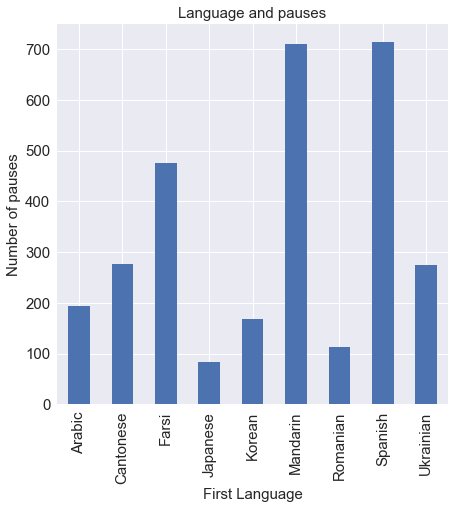

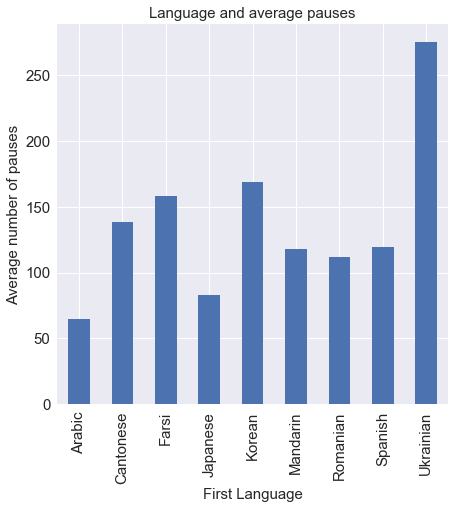

In [120]:
plt.title("Language and pauses", fontsize=15)
list_children.groupby(['first_language'])['pauses'].sum().plot(kind = 'bar', figsize= (7,7), fontsize=15)
plt.xlabel("First Language", fontsize=15)
plt.ylabel("Number of pauses", fontsize=15)
plt.show()

plt.title("Language and average pauses", fontsize=15)
list_children.groupby(['first_language'])['pauses'].mean().plot(kind = 'bar', figsize= (7,7), fontsize=15)
plt.xlabel("First Language", fontsize=15)
plt.ylabel("Average number of pauses", fontsize=15)
plt.show()

In total, children with Spanish as their primary made the most pauses.  On average, the children with Ukrainian as their primary made the most pauses.

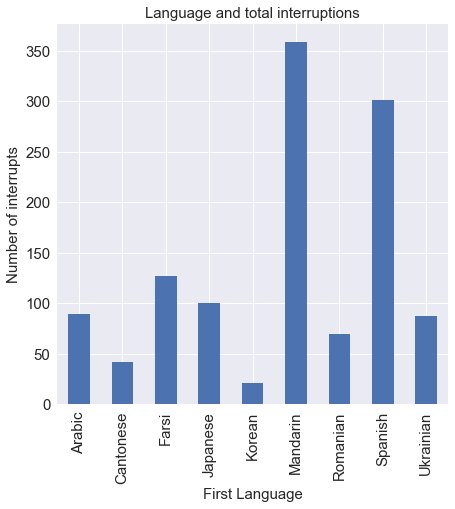

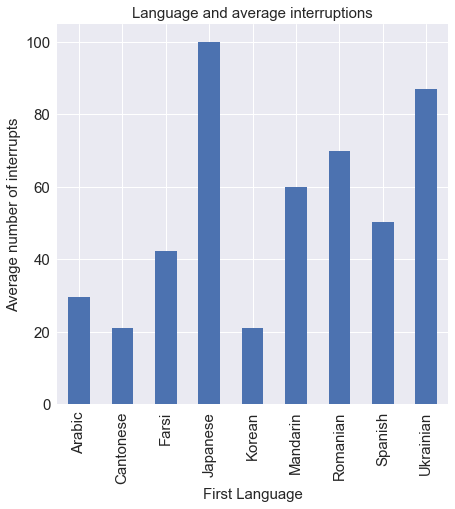

In [121]:
plt.title("Language and total interruptions", fontsize=15)
list_children.groupby(['first_language'])['interrupts'].sum().plot(kind = 'bar', figsize= (7,7), fontsize=15)
plt.xlabel("First Language", fontsize=15)
plt.ylabel("Number of interrupts", fontsize=15)
plt.show()

plt.title("Language and average interruptions", fontsize=15)
list_children.groupby(['first_language'])['interrupts'].mean().plot(kind = 'bar', figsize= (7,7), fontsize=15)
plt.xlabel("First Language", fontsize=15)
plt.ylabel("Average number of interrupts", fontsize=15)
plt.show()

In total, children with Mandarin as their primary made the most interruptions.  On average, the children with Japanese as their primary made the most interruptions.

Now, let's see the total amount of these three imperfections.

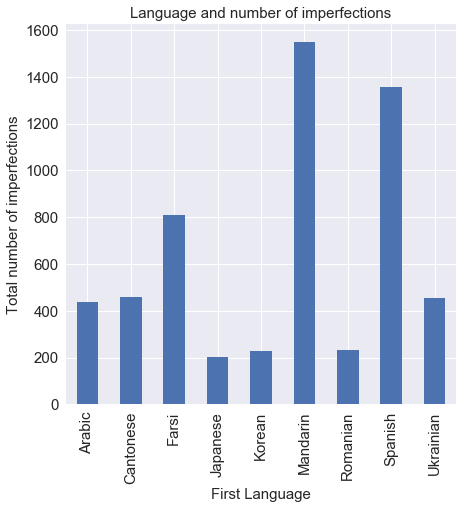

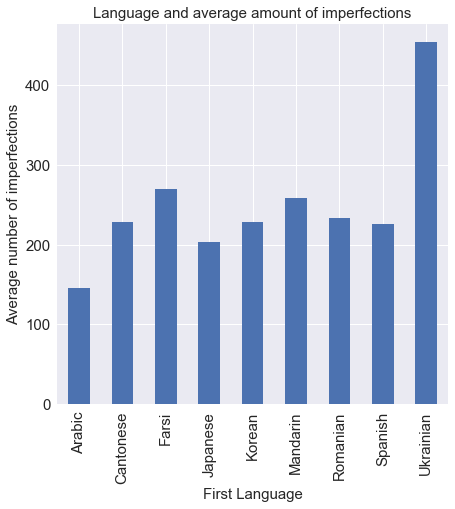

In [122]:
plt.title("Language and number of imperfections", fontsize=15)
list_children.groupby(['first_language'])['imperfections'].sum().plot(kind = 'bar', figsize= (7,7), fontsize=15)
plt.xlabel("First Language", fontsize=15)
plt.ylabel("Total number of imperfections", fontsize=15)
plt.show()

plt.title("Language and average amount of imperfections", fontsize=15)
list_children.groupby(['first_language'])['imperfections'].mean().plot(kind = 'bar', figsize= (7,7), fontsize=15)
plt.xlabel("First Language", fontsize=15)
plt.ylabel("Average number of imperfections", fontsize=15)
plt.show()

It appears that children with Mandarin made the most imperfections, followed by Spanish.  On average, however, children with Ukrainian made the most imperfections.

## Limitations

One thing to be aware is that there is an uneven amount of representation for each language.  Mandarin and Spanish contains the most amount of children while Japanese, Ukrainian, Romanian and Korea only contains one child.